## Data Preprocessing:
#### a) Merging Datasets:

Combined interaction user_data (davranis.csv) with ad details data (ad_listing.csv).
Created 'ad_id' column, prioritizing 'product_id' & 'id'.
Challenges: Dealing with mismatched columns, ensuring data integrity across tables.

#### b) Handling Missing Values:

Identified columns with high missing rates: 'm2_net', 'bina_kat_sayisi', 'cephe', 'sosyal_imkanlar', 'bina_ozellikleri', 'ulasim'.
Decision made to drop these columns due to excessive missing data (over 40% in most cases).
For remaining columns:
Categorical: Filled with 'Unknown' (e.g., 'kategori_1', 'kategori_2', 'il', 'ilce').
Numerical: Filled with median values (e.g., 'm2_gross', 'ilan_fiyat').

Challenges: Balancing data completeness with potential introduction of bias.

#### c) Data Type Conversions:

Converted 'timestamp' to datetime using pd.to_datetime().
Converted 'site_icinde_mi' to boolean.
Challenges: Handling inconsistent date formats, dealing with string representations of numbers.


## Feature Engineering:
#### a) Categorical Features:

##### Room Category:
Parsed complex strings like '3+1', '2&1'.
Created categories: '1 Room', '2 Rooms', '3 Rooms', '4 Rooms', '5 Rooms', '6+ Rooms'.
Challenges: Dealing with unconventional formats, deciding on category boundaries.


##### Floor Category:

Interpreted descriptions like 'Bahçe dublex', 'Yüksek giriş'.
Categories: 'Ground/Near-Ground', 'Low Floor (1-3)', 'Mid Floor (4-9)', 'High Floor (10-20)', 'Very High Floor (21+)', 'Special Type'.
Challenges: Balancing specificity with generalization, handling special cases.


##### Building Age Category:

Parsed strings like '0 (Yeni)', '21 ve üzeri'.
Categories: 'New', '1-2 years', '3-4 years', '5-10 years', '11-15 years', '16-20 years', '21+ years'.
Challenges: Dealing with varying age representations, deciding on meaningful age brackets.



#### b) Numerical Features:

##### m2_gross Categorization:

Different bins for 'arsa' and other property types.
Used pd.cut() to create bins like '0-50', '50-100', '100-150', etc.
Challenges: Deciding on appropriate bin sizes, handling outliers.


##### ilan_fiyat Categorization:

Separate categorization for 'kiralik' (rent) and 'satilik' (sale).
Rent categories: '0-1000', '1000-2000', '2000-3000', etc.
Sale categories: '0-500K', '500K-1M', '1M-1.5M', etc.
Challenges: Dealing with wide price ranges, ensuring categories are meaningful across different markets.



#### c) Interaction Features:

click_count: Sum of 'click' events per ad.
favorite_count: Sum of 'favorite' events per ad.
listing_popularity: Combined score of click_count and favorite_count.
Challenges: Deciding on the weighting of different interaction types, handling ads with no interactions.

## Graph Structure Design:
### a) Ad (Listing) Nodes:

Features included:
Categorical: kategori_1, kategori_2, room_category, floor_category, building_age_category
Location: il, ilce
Numerical (binned): m2_gross_category, ilan_fiyat_category
Boolean: site_icinde_mi
Interaction: click_count, favorite_count, listing_popularity

Challenges: Balancing between including enough information and avoiding overly complex nodes.

### b) User Nodes:

Features included:

Behavioral: average session duration, search frequency
Preferences: most viewed categories, most searched locations
Device info: device_category, browser_size

Challenges: Creating meaningful user profiles with limited interaction data, respecting user privacy.

### c) Location Nodes:

Hierarchical structure: Province → District → Neighborhood
Features for each level:

Aggregated stats: listing_count, total_value, avg_price
Popularity metrics: search_count, view_count, interaction_count
Trend indicators: price_trend, diversity_index


Challenges: Deciding on the appropriate level of granularity, handling locations with few listings.

### d) Node Connections:

User → Listing: INTERACTED_WITH (with interaction type and count)
Listing → Location: LOCATED_IN
Location → Location: PART_OF (for hierarchy)
Challenges: Defining meaningful edge attributes, handling the potentially large number of edges.


### Import the libraries

In [62]:
import pandas as pd
import numpy as np
from collections import Counter

## User Nodes

#####  Place the 'davranis.csv' into: /root/project-1/

In [ ]:
user_data = pd.read_csv('davranis.csv')

### User Features

In [6]:
print(user_data.columns)
print(user_data.dtypes)
print(user_data.head())

Index(['session_id', 'timestamp', 'product_id', 'client_id', 'search_id',
       'device_category', 'page_path', 'product_list_name', 'page_number',
       'query', 'event_type', 'transaction_id', 'transaction_type',
       'ds_search_id', 'il', 'ilce', 'mahalle', 'kategori_3', 'browser_size',
       'product_list_position', 'kategori_1', 'kategori_2', 'others',
       'etl_date'],
      dtype='object')
session_id               object
timestamp                object
product_id               object
client_id                object
search_id                object
device_category          object
page_path                object
product_list_name        object
page_number               int64
query                    object
event_type               object
transaction_id           object
transaction_type         object
ds_search_id              int64
il                       object
ilce                     object
mahalle                  object
kategori_3               object
browser_size     

In [7]:
empty_groups = [client_id for client_id, group in user_data.groupby('client_id') if group.empty]
print(f"Number of empty groups: {len(empty_groups)}")
if empty_groups:
    print("Client IDs with empty groups:", empty_groups)

Number of empty groups: 0


### Engineering User Features

In [8]:
def create_user_features(group):
    features = {}
    
    def safe_first(series):
        return series.iloc[0] if not series.empty else None
    
    def safe_mode(series):
        mode = series.mode()
        return mode.iloc[0] if not mode.empty else None
    
    # Static features
    features['device_category'] = safe_first(group.get('device_category', pd.Series()))
    features['preferred_browser_size'] = safe_mode(group.get('browser_size', pd.Series()))
    
    # Interaction counts
    features['total_interactions'] = len(group)
    features['unique_products_viewed'] = group.get('product_id', pd.Series()).nunique()
    
    # Query complexity
    query_series = group.get('query', pd.Series())
    features['avg_query_complexity'] = query_series.str.count('&').mean() + 1 if not query_series.empty else 0
    
    # Activity dates
    timestamp_series = group.get('timestamp', pd.Series())
    if not timestamp_series.empty:
        features['first_activity_date'] = timestamp_series.min()
        features['last_activity_date'] = timestamp_series.max()
        features['activity_recency'] = (pd.Timestamp.now() - pd.to_datetime(features['last_activity_date'])).total_seconds() / (24 * 3600)  # in days
    
    # Event type counts
    event_type_series = group.get('event_type', pd.Series())
    if not event_type_series.empty:
        event_counts = event_type_series.value_counts()
        features['click_count'] = event_counts.get('click', 0)
        features['view_count'] = event_counts.get('view', 0)
        features['favorite_count'] = event_counts.get('favorite', 0)
        features['click_rate'] = features['click_count'] / features['total_interactions'] if features['total_interactions'] > 0 else 0
        features['favorite_rate'] = features['favorite_count'] / features['total_interactions'] if features['total_interactions'] > 0 else 0
    
    # Category preferences
    for cat in ['kategori_1', 'kategori_2', 'kategori_3']:
        cat_series = group.get(cat, pd.Series())
        if not cat_series.empty:
            features[f'most_frequent_{cat}'] = safe_mode(cat_series)
            counter = Counter(cat_series.dropna())
            features[f'{cat}_preference'] = dict(counter.most_common(3))
    
    # Location preferences
    for loc in ['il', 'ilce']:
        loc_series = group.get(loc, pd.Series())
        if not loc_series.empty:
            features[f'most_searched_{loc}'] = safe_mode(loc_series)
            counter = Counter(loc_series.dropna())
            features[f'{loc}_preference'] = dict(counter.most_common(5))
    
    # Price interactions
    others_series = group.get('others', pd.Series())
    if not others_series.empty:
        def extract_price(others):
            try:
                return int(eval(others).get('max_fiyat', [0])[0])
            except:
                return 0
        
        prices = others_series.apply(extract_price)
        features['avg_price_interaction'] = prices.mean()
        # features['max_price_interaction'] = prices.max()
        # features['min_price_interaction'] = prices[prices > 0].min() if (prices > 0).any() else 0
    
    return features


#### User Nodes

In [9]:
# create user nodes
user_nodes = {}
for client_id, group in user_data.groupby('client_id'):
    try:
        user_nodes[client_id] = create_user_features(group)
    except Exception as e:
        print(f"Error processing client_id {client_id}: {str(e)}")

# convert to df
user_nodes_df = pd.DataFrame.from_dict(user_nodes, orient='index')

In [10]:
print(user_nodes_df.shape)

(131110, 24)


In [11]:
print(user_nodes_df.head())

                         device_category preferred_browser_size  \
5a0addd7c5b4eab21e04a7c5          mobile                360x560   
DS1000000804.1687105942           mobile                410x720   
DS1000017540.1688407967           mobile                380x700   
DS1000030923.1667739739           mobile                360x670   
DS1000036432.1688496254           mobile                390x720   

                          total_interactions  unique_products_viewed  \
5a0addd7c5b4eab21e04a7c5                   1                       1   
DS1000000804.1687105942                    1                       1   
DS1000017540.1688407967                    1                       1   
DS1000030923.1667739739                    1                       1   
DS1000036432.1688496254                    1                       1   

                          avg_query_complexity      first_activity_date  \
5a0addd7c5b4eab21e04a7c5                   1.0  2023-07-03 21:09:31.235   
DS1000000804.1

In [12]:
user_nodes_df.to_csv('user_nodes.csv', index=False)

In [13]:
print(user_nodes_df.isnull().sum())

device_category                 0
preferred_browser_size         56
total_interactions              0
unique_products_viewed          0
avg_query_complexity            0
first_activity_date             0
last_activity_date              0
activity_recency                0
click_count                     0
view_count                      0
favorite_count                  0
click_rate                      0
favorite_rate                   0
most_frequent_kategori_1        0
kategori_1_preference           0
most_frequent_kategori_2        0
kategori_2_preference           0
most_frequent_kategori_3    41349
kategori_3_preference           0
most_searched_il             1732
il_preference                   0
most_searched_ilce          24120
ilce_preference                 0
avg_price_interaction           0
dtype: int64


In [14]:
print(user_nodes_df.describe())

       total_interactions  unique_products_viewed  avg_query_complexity  \
count       131110.000000           131110.000000         131110.000000   
mean             2.466135                2.265228              1.230560   
std              2.552342                2.183790              1.508156   
min              1.000000                1.000000              1.000000   
25%              1.000000                1.000000              1.000000   
50%              2.000000                1.000000              1.000000   
75%              3.000000                3.000000              1.000000   
max             68.000000               42.000000             94.000000   

       activity_recency    click_count  view_count  favorite_count  \
count     131110.000000  131110.000000    131110.0        131110.0   
mean         377.742949       2.247967         0.0             0.0   
std            0.586521       2.406426         0.0             0.0   
min          347.133879       0.000000      

#### Correlation between engineered features' correlation map

Engineered features shouldn't be highly correlated. 

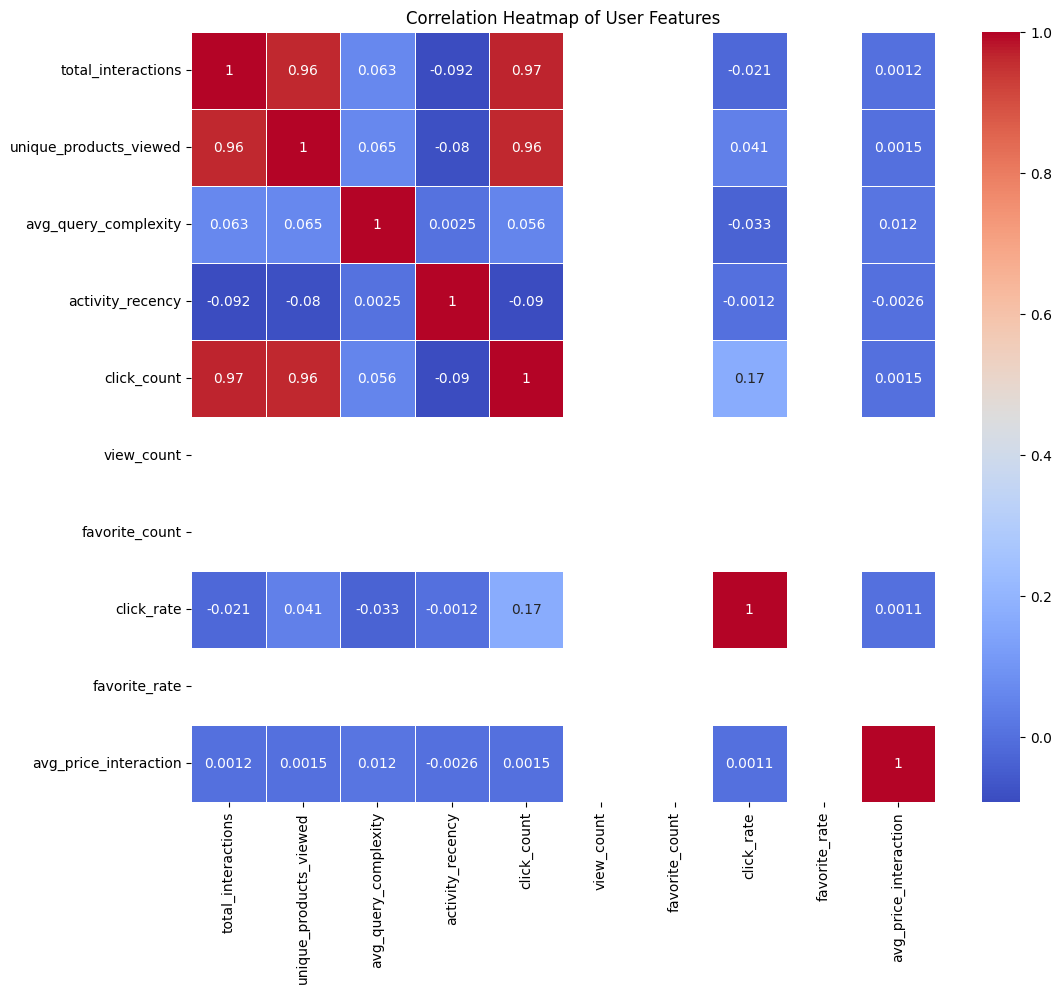

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numerical_features = user_nodes_df.select_dtypes(include=[np.number]).columns
corr = user_nodes_df[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of User Features")
plt.show()

#### Unique value count in engineered df and the original

In [17]:
for col in user_data.columns:
    print(f"{col} {len(pd.unique(user_data[col]))}")
    

session_id 162863
timestamp 322893
product_id 78828
client_id 131110
search_id 212146
device_category 3
page_path 48327
product_list_name 2
page_number 1
query 40499
event_type 2
transaction_id 28605
transaction_type 6
ds_search_id 174577
il 82
ilce 1991
mahalle 10201
kategori_3 177
browser_size 1092
product_list_position 30
kategori_1 2
kategori_2 7
others 9124
etl_date 2


In [18]:
# Function to flatten dictionary columns
def flatten_dict_col(column):
    return column.apply(lambda x: list(x.keys()) if isinstance(x, dict) else [])

unique_counts = {}

for col in user_nodes_df.columns:
    if user_nodes_df[col].apply(lambda x: isinstance(x, dict)).any():
        user_nodes_df[col + '_flat'] = flatten_dict_col(user_nodes_df[col])
        unique_counts[col + '_flat'] = sum(Counter(user_nodes_df[col + '_flat'].sum()).values())
    else:
        # Count unique values for non-dictionary columns
        unique_counts[col] = len(pd.unique(user_nodes_df[col]))

print(unique_counts)


{'device_category': 3, 'preferred_browser_size': 1074, 'total_interactions': 47, 'unique_products_viewed': 40, 'avg_query_complexity': 508, 'first_activity_date': 131026, 'last_activity_date': 131031, 'activity_recency': 131110, 'click_count': 47, 'view_count': 1, 'favorite_count': 1, 'click_rate': 144, 'favorite_rate': 1, 'most_frequent_kategori_1': 2, 'kategori_1_preference_flat': 132752, 'most_frequent_kategori_2': 7, 'kategori_2_preference_flat': 132940, 'most_frequent_kategori_3': 157, 'kategori_3_preference_flat': 91938, 'most_searched_il': 82, 'il_preference_flat': 132437, 'most_searched_ilce': 1789, 'ilce_preference_flat': 113358, 'avg_price_interaction': 649}


### Finalize, selection of the User Node Features 

In [19]:

# List of features to keep
features_to_keep = [
    'total_interactions',
    'avg_query_complexity',
    'activity_recency',
    'click_rate',
    'avg_price_interaction',
    'device_category',
    'preferred_browser_size',
    'most_frequent_kategori_1',
    'most_frequent_kategori_2',
    'most_frequent_kategori_3',
    'most_searched_il',
    'most_searched_ilce'
]

# create the new dataframe for further usage (earlier)
user_data_selection= user_nodes_df[features_to_keep].copy()

for feature in features_to_keep:
    if feature not in user_data_selection.columns and feature in user_data.columns:
        user_data_selection[feature] = user_data[feature]

user_data_selection.reset_index(inplace=True)
user_data_selection.rename(columns={'index': 'client_id'}, inplace=True)

# first few rows and info of the new dataframe
print(user_data_selection.head())
print(user_data_selection.info())
print(user_data_selection.isnull().sum())

                  client_id  total_interactions  avg_query_complexity  \
0  5a0addd7c5b4eab21e04a7c5                   1                   1.0   
1   DS1000000804.1687105942                   1                   1.0   
2   DS1000017540.1688407967                   1                   1.0   
3   DS1000030923.1667739739                   1                   1.0   
4   DS1000036432.1688496254                   1                   1.0   

   activity_recency  click_rate  avg_price_interaction device_category  \
0        377.928795         1.0                    0.0          mobile   
1        377.458227         1.0                    0.0          mobile   
2        378.049497         1.0                    0.0          mobile   
3        377.887560         1.0                    0.0          mobile   
4        377.027780         0.0                    0.0          mobile   

  preferred_browser_size most_frequent_kategori_1 most_frequent_kategori_2  \
0                360x560              

## AD NODES

In [20]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone
from sklearn.preprocessing import KBinsDiscretizer


#####  Place the 'davranis.csv' & 'ilan_bilgileri.csv' into: /root/project-1/
For the listing nodes, we will be using both interaction file and listing file by merging them. 

In [21]:
path_data = 'davranis.csv'
path_ad = 'ilan_bilgileri.csv'

interaction = pd.read_csv(path_data)
ad_details = pd.read_csv(path_ad)

# Convert product_id from object to int64
interaction['product_id'] = pd.to_numeric(interaction['product_id'], errors='coerce').astype('Int64')

/tmp/ipykernel_1037371/2578401916.py:5: DtypeWarning: Columns (20,23) have mixed types. Specify dtype option on import or set low_memory=False.
  ad_details = pd.read_csv(path_ad)


Ensure, 'product_id' == 'id'

In [22]:
interaction['product_id'].head()

0    13505245
1    13505409
2    13505693
3    13505616
4    13505616
Name: product_id, dtype: Int64

In [23]:
ad_details['id'].head()

0     8573826
1     9287649
2     9759525
3     9915149
4    10625509
Name: id, dtype: int64

In [24]:
nan_count_ad = ad_details.isna().sum()
nan_count_int = interaction.isna().sum()
print(f"ad nan values {nan_count_ad}, interaction nan values {nan_count_int}, ")

ad nan values id                       0
category_id              0
kategori_1               0
kategori_2               0
kategori_3               0
mahalle                  0
ilce                   528
il                       0
created_at               0
updated_at               0
ilan_baslik              0
ilan_fiyat             548
ilan_sahip_adi         867
site_icinde_mi           0
m2_gross               568
m2_net              150775
bina_kat_sayisi     150458
etl_date                 0
row_num                  0
cephe               282407
sosyal_imkanlar     245633
bina_ozellikleri    205988
ulasim              220979
oda_sayisi           79093
ilan_kat_sayisi      79025
bina_yasi            76734
dtype: int64, interaction nan values session_id                    0
timestamp                     0
product_id                  381
client_id                     0
search_id                     0
device_category               0
page_path                     0
product_list_name      

In [25]:
interaction['product_id'] = pd.to_numeric(interaction['product_id'], errors='coerce').astype('Int64')

# Perform the merge
merged_df = pd.merge(interaction, ad_details, left_on='product_id', right_on='id', how='outer', suffixes=('_table1', '_ad_details'))
merged_df['ad_id'] = merged_df['product_id'].fillna(merged_df['id'])

In [27]:
merged_df.columns

Index(['session_id', 'timestamp', 'product_id', 'client_id', 'search_id',
       'device_category', 'page_path', 'product_list_name', 'page_number',
       'query', 'event_type', 'transaction_id', 'transaction_type',
       'ds_search_id', 'il_table1', 'ilce_table1', 'mahalle_table1',
       'kategori_3_table1', 'browser_size', 'product_list_position',
       'kategori_1_table1', 'kategori_2_table1', 'others', 'etl_date_table1',
       'id', 'category_id', 'kategori_1_ad_details', 'kategori_2_ad_details',
       'kategori_3_ad_details', 'mahalle_ad_details', 'ilce_ad_details',
       'il_ad_details', 'created_at', 'updated_at', 'ilan_baslik',
       'ilan_fiyat', 'ilan_sahip_adi', 'site_icinde_mi', 'm2_gross', 'm2_net',
       'bina_kat_sayisi', 'etl_date_ad_details', 'row_num', 'cephe',
       'sosyal_imkanlar', 'bina_ozellikleri', 'ulasim', 'oda_sayisi',
       'ilan_kat_sayisi', 'bina_yasi', 'ad_id'],
      dtype='object')

In [28]:
merged_df.head()

,session_id,timestamp,product_id,client_id,search_id,device_category,page_path,product_list_name,page_number,query,...,etl_date_ad_details,row_num,cephe,sosyal_imkanlar,bina_ozellikleri,ulasim,oda_sayisi,ilan_kat_sayisi,bina_yasi,ad_id
0,c4b46633-331e-4f3a-939d-acb1d1be86d0,2023-07-03 15:51:13.343,127078,DS552217351.1688399435,jA90xbkBNYpKk3xdsDU857AZy7DP6dRC,mobile,/satilik-arsa/istanbul-basaksehir-bahcesehir-2...,ilan-listeleme,1.0,/satilik-arsa/istanbul-basaksehir-bahcesehir-2...,...,2023-07-09 00:12:23.964997 UTC,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127078
1,f7046021-ac95-49bd-b441-cb05db99ad93,2023-07-04 15:16:48.208,325571,DS1933796731.1614845806,s6nerUFduZnngFs2Yzz0ZwGcGak5L8yN,mobile,/satilik-konut/istanbul-sancaktepe-veysel-kara...,ilan-listeleme,1.0,/satilik-konut/istanbul-sancaktepe-veysel-kara...,...,2023-07-09 00:12:23.964997 UTC,1.0,NaN,NaN,PVC Doğrama&Isıcam,Caddeye Yakın&Okula Yakın,3+1,NaN,21 ve üzeri,325571
2,82e0c2e5-1b5a-4e02-b31c-8f608e4c9117,2023-07-04 13:54:32.328,325571,DS1140451396.1688478779,rv0WfYJf3aeqVidGY5EB1G4E8aDQkOsJ,mobile,/satilik-bina/istanbul-sancaktepe/,ilan-listeleme,1.0,/satilik-bina/istanbul-sancaktepe/,...,2023-07-09 00:12:23.964997 UTC,1.0,NaN,NaN,PVC Doğrama&Isıcam,Caddeye Yakın&Okula Yakın,3+1,NaN,21 ve üzeri,325571
3,a6b67c9a-9493-4e3f-b3c4-bee14ce530bf,2023-07-03 07:36:18.791,325571,DS1467654928.1686174497,rzcOkLp1KdjERByPPmCwQSkmojaE4N0h,mobile,/satilik-bina/istanbul-sancaktepe/,ilan-listeleme,1.0,/satilik-bina/istanbul-sancaktepe/,...,2023-07-09 00:12:23.964997 UTC,1.0,NaN,NaN,PVC Doğrama&Isıcam,Caddeye Yakın&Okula Yakın,3+1,NaN,21 ve üzeri,325571
4,c264e6ba-5f4f-467b-9a49-394458da57b8,2023-07-03 08:47:01.930,325571,DS1467654928.1686174497,hiIZEnJi80rvJ3VLvzb7kwYNOQf6bvni,mobile,/satilik-bina/istanbul-sancaktepe/,ilan-listeleme,1.0,/satilik-bina/istanbul-sancaktepe/,...,2023-07-09 00:12:23.964997 UTC,1.0,NaN,NaN,PVC Doğrama&Isıcam,Caddeye Yakın&Okula Yakın,3+1,NaN,21 ve üzeri,325571


In [29]:
# list of columns to drop after merging
columns_to_drop = [
    'id', 'category_id', 'kategori_1_table1', 'kategori_2_table1', 'kategori_3_table1',
    'mahalle_table1', 'ilce_table1', 'il_table1', 'etl_date_table1',
    'm2_net', 'bina_kat_sayisi', 'cephe', 'sosyal_imkanlar', 'bina_ozellikleri', 'ulasim',
    'transaction_id', 'transaction_type', 'mahalle_table1', 'kategori_3_ad_details', 'others'
]

merged_df = merged_df.drop(columns=columns_to_drop)

print(f"SHape of merged DataFrame: {merged_df.shape}")
print("\nColumns in merged DataFrame:")
print(merged_df.columns)

merged_df.to_csv('merged_data.csv', index=False)

SHape of merged DataFrame: (621512, 32)

Columns in merged DataFrame:
Index(['session_id', 'timestamp', 'product_id', 'client_id', 'search_id',
       'device_category', 'page_path', 'product_list_name', 'page_number',
       'query', 'event_type', 'ds_search_id', 'browser_size',
       'product_list_position', 'kategori_1_ad_details',
       'kategori_2_ad_details', 'mahalle_ad_details', 'ilce_ad_details',
       'il_ad_details', 'created_at', 'updated_at', 'ilan_baslik',
       'ilan_fiyat', 'ilan_sahip_adi', 'site_icinde_mi', 'm2_gross',
       'etl_date_ad_details', 'row_num', 'oda_sayisi', 'ilan_kat_sayisi',
       'bina_yasi', 'ad_id'],
      dtype='object')


#### Conversions

In [30]:
# 'created_at' to datetime
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'], errors='coerce')
merged_df['created_at'] = merged_df['created_at'].dt.tz_localize(None)
now = datetime.now()

#### Unique /Continues Variables

In [31]:
ad_path = 'merged_data.csv'
merged_df = pd.read_csv(ad_path)

def write_unique_values_to_file(df, columns, filename):
    with open(filename, 'w') as f:
        for col in columns:
            unique_values = df[col].unique()
            f.write(f"Unique values in {col}:\n")
            for value in unique_values:
                f.write(f"{value}\n")
            f.write("\n")

# Use the function
columns_to_check = ['m2_gross', 'ilan_fiyat',  'oda_sayisi', 'ilan_kat_sayisi', 'bina_yasi']
write_unique_values_to_file(merged_df, columns_to_check, 'unique_values.txt')

/tmp/ipykernel_1037371/1926250230.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(ad_path)


### Room Categorization

In [32]:
import re

def categorize_rooms(value):
    if pd.isna(value):
        return 'Unknown'
    
    value = str(value).lower()
    
    # Helper function to sum up room numbers
    def sum_rooms(s):
        return sum(int(x) for x in re.findall(r'\d+', s))
    
    # Handle complex cases with '&' or '+'
    if '&' in value or '+' in value:
        total_rooms = sum_rooms(value)
    else:
        try:
            total_rooms = float(value)
        except ValueError:
            return 'Other'
    
    if total_rooms < 1:
        return '1 Room'
    elif total_rooms < 2:
        return '1 Room'
    elif total_rooms < 3:
        return '2 Rooms'
    elif total_rooms < 4:
        return '3 Rooms'
    elif total_rooms < 5:
        return '4 Rooms'
    elif total_rooms < 6:
        return '5 Rooms'
    else:
        return '6+ Rooms'

# Apply the updated function
merged_df['room_category'] = np.where(
    (merged_df['kategori_2_ad_details'] == 'konut') | (merged_df['kategori_2_ad_details'].isna()),
    merged_df['oda_sayisi'].apply(categorize_rooms),
    'Not-Applicable'
)

# Print the updated distribution
print("Updated distribution of room categories:")
print(merged_df['room_category'].value_counts(normalize=True))

Updated distribution of room categories:
room_category
3 Rooms           0.277769
4 Rooms           0.277502
Not-Applicable    0.187946
2 Rooms           0.115213
5 Rooms           0.060416
6+ Rooms          0.048474
Other             0.018479
1 Room            0.008360
Unknown           0.005841
Name: proportion, dtype: float64


For better approach, the room count of nan values could be extracted from the title(if exist)

### ilan_kat_sayisi categorization

In [33]:
def categorize_floor(row):
    value = row['ilan_kat_sayisi']
    kategori_2 = row['kategori_2_ad_details']

    # check if 'arsa' or 'isyeri'
    if kategori_2 in ['arsa', 'isyeri']:
        return 'Not-Applicable'

    if pd.isna(value):
        return 'Unknown'
    
    value = str(value).lower()
    
    # all types of 'giriş katı'
    if any(term in value for term in ['giriş', 'bahçe katı', 'yüksek giriş', 'düz giriş']):
        return 'Ground/Near-Ground'
    
    # alternative types
    if any(term in value for term in ['dublex', 'dubleks', 'villa', 'müstakil', 'çatı katı', 'penthouse']):
        return 'Special Type'
    
    # below ground floors
    if any(term in value for term in ['bodrum', 'kot']):
        return 'Below Ground'
    
    try:
        floor = int(re.findall(r'\d+', value)[0])
    except (ValueError, IndexError):
        return 'Other'
    
    # categorize based on floor number
    if 1 <= floor <= 3:
        return 'Low Floor (1-3)'
    elif 4 <= floor <= 9:
        return 'Mid Floor (4-9)'
    elif 10 <= floor <= 20:
        return 'High Floor (10-20)'
    elif floor > 20:
        return 'Very High Floor (21+)'
    else:
        return 'Other'

# apply the categorization
merged_df['floor_category'] = merged_df.apply(categorize_floor, axis=1)

print(merged_df['floor_category'].value_counts(normalize=True))
residential_df = merged_df[merged_df['kategori_2_ad_details'].isin(['konut', np.nan])]

print("\nDistribution of floor categories for residential properties:")
print(residential_df['floor_category'].value_counts(normalize=True))

# the count of 'Unknown' for residential properties
unknown_count = (residential_df['floor_category'] == 'Unknown').sum()
print(f"\nNumber of 'Unknown' floor categories for residential properties: {unknown_count}")

floor_category
Low Floor (1-3)          0.352500
Not-Applicable           0.186949
Mid Floor (4-9)          0.175694
Ground/Near-Ground       0.146264
Special Type             0.085181
High Floor (10-20)       0.023103
Below Ground             0.018218
Unknown                  0.010042
Very High Floor (21+)    0.002048
Name: proportion, dtype: float64

Distribution of floor categories for residential properties:
floor_category
Low Floor (1-3)          0.434085
Mid Floor (4-9)          0.216358
Ground/Near-Ground       0.180117
Special Type             0.104896
High Floor (10-20)       0.028451
Below Ground             0.022435
Unknown                  0.011137
Very High Floor (21+)    0.002522
Name: proportion, dtype: float64

Number of 'Unknown' floor categories for residential properties: 5621


### building age

In [35]:
def categorize_building_age(row):
    kategori_2 = row['kategori_2_ad_details']
    value = row['bina_yasi']

    # check if it's 'konut' or NaN in kategori_2
    if kategori_2 != 'konut' and not pd.isna(kategori_2):
        return 'Not Applicable'

    if pd.isna(value):
        return 'Unknown'
    
    value = str(value).lower()
    
    if value == '0 (yeni)' or value == '0':
        return 'New'
    elif value in ['1', '2']:
        return '1-2 years'
    elif value in ['3', '4']:
        return '3-4 years'
    elif value == '5-10':
        return '5-10 years'
    elif value == '11-15':
        return '11-15 years'
    elif value == '16-20':
        return '16-20 years'
    elif value == '21 ve üzeri':
        return '21+ years'
    else:
        try:
            age = int(value)
            if age == 0:
                return 'New'
            elif 1 <= age <= 2:
                return '1-2 years'
            elif 3 <= age <= 4:
                return '3-4 years'
            elif 5 <= age <= 10:
                return '5-10 years'
            elif 11 <= age <= 15:
                return '11-15 years'
            elif 16 <= age <= 20:
                return '16-20 years'
            elif age >= 21:
                return '21+ years'
            else:
                return 'Other'
        except ValueError:
            return 'Other'

merged_df['building_age_category'] = merged_df.apply(categorize_building_age, axis=1)

print("Overall distribution of building age categories:")
print(merged_df['building_age_category'].value_counts(normalize=True))

# print the distribution for residential properties only
residential_df = merged_df[(merged_df['kategori_2_ad_details'] == 'konut') | (merged_df['kategori_2_ad_details'].isna())]
print("\nDistribution of building age categories for residential properties:")
print(residential_df['building_age_category'].value_counts(normalize=True))

# print the count of each category for residential properties
print("\nCount of each building age category for residential properties:")
print(residential_df['building_age_category'].value_counts())

# print the count of 'Unknown' and 'Other' categories for residential properties
unknown_count = (residential_df['building_age_category'] == 'Unknown').sum()
other_count = (residential_df['building_age_category'] == 'Other').sum()
print(f"\nNumber of 'Unknown' building age categories for residential properties: {unknown_count}")
print(f"Number of 'Other' building age categories for residential properties: {other_count}")

# print the count of 'Not Applicable'
not_applicable_count = (merged_df['building_age_category'] == 'Not Applicable').sum()
print(f"\nNumber of 'Not Applicable' building age categories: {not_applicable_count}")

Overall distribution of building age categories:
building_age_category
Not Applicable    0.187946
5-10 years        0.178791
New               0.174610
21+ years         0.141515
11-15 years       0.095260
3-4 years         0.087704
16-20 years       0.077912
1-2 years         0.050424
Unknown           0.005839
Name: proportion, dtype: float64

Distribution of building age categories for residential properties:
building_age_category
5-10 years     0.220172
New            0.215022
21+ years      0.174268
11-15 years    0.117307
3-4 years      0.108003
16-20 years    0.095944
1-2 years      0.062094
Unknown        0.007190
Name: proportion, dtype: float64

Count of each building age category for residential properties:
building_age_category
5-10 years     111121
New            108522
21+ years       87953
11-15 years     59205
3-4 years       54509
16-20 years     48423
1-2 years       31339
Unknown          3629
Name: count, dtype: int64

Number of 'Unknown' building age categories for

In [36]:
# Handle missing values
categorical_cols = ['kategori_1_ad_details', 'kategori_2_ad_details', 'room_category', 'floor_category', 'il_ad_details', 'ilce_ad_details']
merged_df[categorical_cols] = merged_df[categorical_cols].fillna('Unknown')

In [37]:
def categorize_m2_gross(row):
    if row['kategori_2_ad_details'] == 'arsa':  # For land
        bins = [0, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, float('inf')]
        labels = ['0-100', '100-500', '500-1000', '1000-5000', '5000-10000', '10000-50000', 
                  '50000-100000', '100000-500000', '500000-1000000', '1000000+']
    else:  # For residency and other property types
        bins = [0, 50, 70, 90, 110, 130, 150, 200, 250, 300, 500, float('inf')]
        labels = ['0-50', '50-70', '70-90', '90-110', '110-130', '130-150', '150-200', 
                  '200-250', '250-300', '300-500', '500+']
    
    return pd.cut([row['m2_gross']], bins=bins, labels=labels, include_lowest=True)[0]

merged_df['m2_gross_category'] = merged_df.apply(categorize_m2_gross, axis=1)
# Print the distribution of the new categories
print("Distribution of m2_gross_category:")
print(merged_df['m2_gross_category'].value_counts())


Distribution of m2_gross_category:
m2_gross_category
90-110            85296
110-130           84700
150-200           76670
130-150           71201
70-90             70540
50-70             53055
0-50              27454
1000-5000         26426
200-250           25193
100-500           21081
300-500           15402
500-1000          12627
250-300           11368
5000-10000        11362
500+              11223
10000-50000       11110
0-100              1010
50000-100000        868
100000-500000       600
1000000+            349
500000-1000000      123
Name: count, dtype: int64


In [38]:
# all types of 'kategori_1'
print(merged_df['kategori_1_ad_details'].unique())

['sale' 'rent' 'daily_rent' 'flat_for_land' 'Unknown' 'sublet']


In [39]:
filtered_kategori_1 = merged_df[merged_df['kategori_1_ad_details'] == 'flat_for_land']
print(len(filtered_kategori_1['m2_gross']))

574


In [40]:
print(merged_df['kategori_1_ad_details'].value_counts(dropna=False))

kategori_1_ad_details
sale             389131
rent             185840
daily_rent        40303
Unknown            3186
sublet             2478
flat_for_land       574
Name: count, dtype: int64


In [41]:
print(f"Number of NaN values in ilan_fiyat: {merged_df['ilan_fiyat'].isna().sum()}")

Number of NaN values in ilan_fiyat: 3758


In [42]:
def categorize_ilan_fiyat(row):
    if pd.isna(row['ilan_fiyat']):
        return 'Unknown'
    
    if pd.isna(row['kategori_1_ad_details']):
        return 'Unknown'
    
    if row['kategori_1_ad_details'] in ['rent', 'daily_rent', 'sublet']:  # For rent
        bins = [0, 1000, 2000, 3000, 5000, 7500, 10000, 15000, 20000, 30000, float('inf')]
        labels = ['0-1000', '1000-2000', '2000-3000', '3000-5000', '5000-7500', '7500-10000', 
                  '10000-15000', '15000-20000', '20000-30000', '30000+']
    elif row['kategori_1_ad_details'] == 'sale':  # For sale
        bins = [0, 500000, 1000000, 1500000, 2000000, 3000000, 5000000, 7500000, 10000000, 15000000, float('inf')]
        labels = ['0-500K', '500K-1M', '1M-1.5M', '1.5M-2M', '2M-3M', '3M-5M', '5M-7.5M', 
                  '7.5M-10M', '10M-15M', '15M+']
    elif row['kategori_1_ad_details'] == 'flat_for_land':
        return 'Not-Applicable'
    else:
        print(f"Unexpected kategori_1_ad_details: {row['kategori_1_ad_details']}")
        return 'Other'
    
    try:
        return pd.cut([row['ilan_fiyat']], bins=bins, labels=labels, include_lowest=True)[0]
    except ValueError as e:
        print(f"Error categorizing ilan_fiyat: {row['ilan_fiyat']} for kategori_1_ad_details: {row['kategori_1_ad_details']}")
        print(f"Error message: {str(e)}")
        return 'Error'

# create a new column 'ilan_fiyat_category'
merged_df['ilan_fiyat_category'] = merged_df.apply(categorize_ilan_fiyat, axis=1)
print("\nDistribution of ilan_fiyat_category:")
print(merged_df['ilan_fiyat_category'].value_counts())


Distribution of ilan_fiyat_category:
ilan_fiyat_category
2M-3M             74556
1.5M-2M           61380
3M-5M             59074
1M-1.5M           59032
500K-1M           44817
7500-10000        42424
5000-7500         39746
0-1000            35574
10000-15000       32095
5M-7.5M           27768
3000-5000         25687
0-500K            21888
15M+              16009
30000+            15310
7.5M-10M          12980
1000-2000         12030
10M-15M           11627
2000-3000         10129
15000-20000        9461
20000-30000        6165
Unknown            3758
Not-Applicable        2
Name: count, dtype: int64


## Creating the Ad Features

In [64]:
def create_ad_features(group):
    features = {}

    features['ad_id'] = group.name
    
    # Basic Information
    features['kategori_1'] = group['kategori_1_ad_details'].iloc[0] if pd.notna(group['kategori_1_ad_details'].iloc[0]) else pd.NA
    features['kategori_2'] = group['kategori_2_ad_details'].iloc[0] if pd.notna(group['kategori_2_ad_details'].iloc[0]) else pd.NA
    
    # Use the new categories
    features['room_category'] = group['room_category'].iloc[0] if pd.notna(group['room_category'].iloc[0]) else pd.NA
    features['floor_category'] = group['floor_category'].iloc[0] if pd.notna(group['floor_category'].iloc[0]) else pd.NA
    features['building_age_category'] = group['building_age_category'].iloc[0] if pd.notna(group['building_age_category'].iloc[0]) else pd.NA
    features['m2_gross_category'] = group['m2_gross_category'].iloc[0] if pd.notna(group['m2_gross_category'].iloc[0]) else pd.NA
    features['ilan_fiyat_category'] = group['ilan_fiyat_category'].iloc[0] if pd.notna(group['ilan_fiyat_category'].iloc[0]) else pd.NA
    
    # Location
    features['il'] = group['il_ad_details'].iloc[0] if pd.notna(group['il_ad_details'].iloc[0]) else pd.NA
    features['ilce'] = group['ilce_ad_details'].iloc[0] if pd.notna(group['ilce_ad_details'].iloc[0]) else pd.NA
    features['mahalle'] = group['mahalle_ad_details'].iloc[0] if pd.notna(group['ilce_ad_details'].iloc[0]) else pd.NA
        
    # Encoded Features
    features['site_icinde_mi'] = group['site_icinde_mi'].iloc[0] if pd.notna(group['site_icinde_mi'].iloc[0]) else pd.NA
    
    # Interaction Features
    features['click_count'] = group['event_type'].eq('click').sum()
    features['favorite_count'] = group['event_type'].eq('favorite').sum()
    
    # Listing Popularity
    features['listing_popularity'] = features['click_count'] + features['favorite_count']
    
    return pd.DataFrame(features, index=[0])

# Apply the function to create ad features
ad_nodes = merged_df.groupby('ad_id').apply(create_ad_features).reset_index(drop=True)
print(ad_nodes.head(20))
print("\nColumns:")
print(ad_nodes.columns)


        ad_id kategori_1 kategori_2   room_category      floor_category  \
0    127078.0       sale       arsa  Not-Applicable      Not-Applicable   
1    325571.0       sale      konut         4 Rooms             Unknown   
2    645128.0       rent      konut         4 Rooms        Special Type   
3    694703.0       sale       arsa  Not-Applicable      Not-Applicable   
4   1132386.0       rent      konut         4 Rooms  Ground/Near-Ground   
5   1445293.0       rent     isyeri  Not-Applicable      Not-Applicable   
6   1543079.0       rent     isyeri  Not-Applicable      Not-Applicable   
7   1863656.0       sale     isyeri  Not-Applicable      Not-Applicable   
8   2031746.0       sale       arsa  Not-Applicable      Not-Applicable   
9   2698452.0       rent      konut         2 Rooms     Low Floor (1-3)   
10  2729445.0       sale      konut         4 Rooms  High Floor (10-20)   
11  2822222.0       sale      konut        6+ Rooms        Special Type   
12  2888159.0       rent 

/tmp/ipykernel_1037371/1491979294.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ad_nodes = merged_df.groupby('ad_id').apply(create_ad_features).reset_index(drop=True)


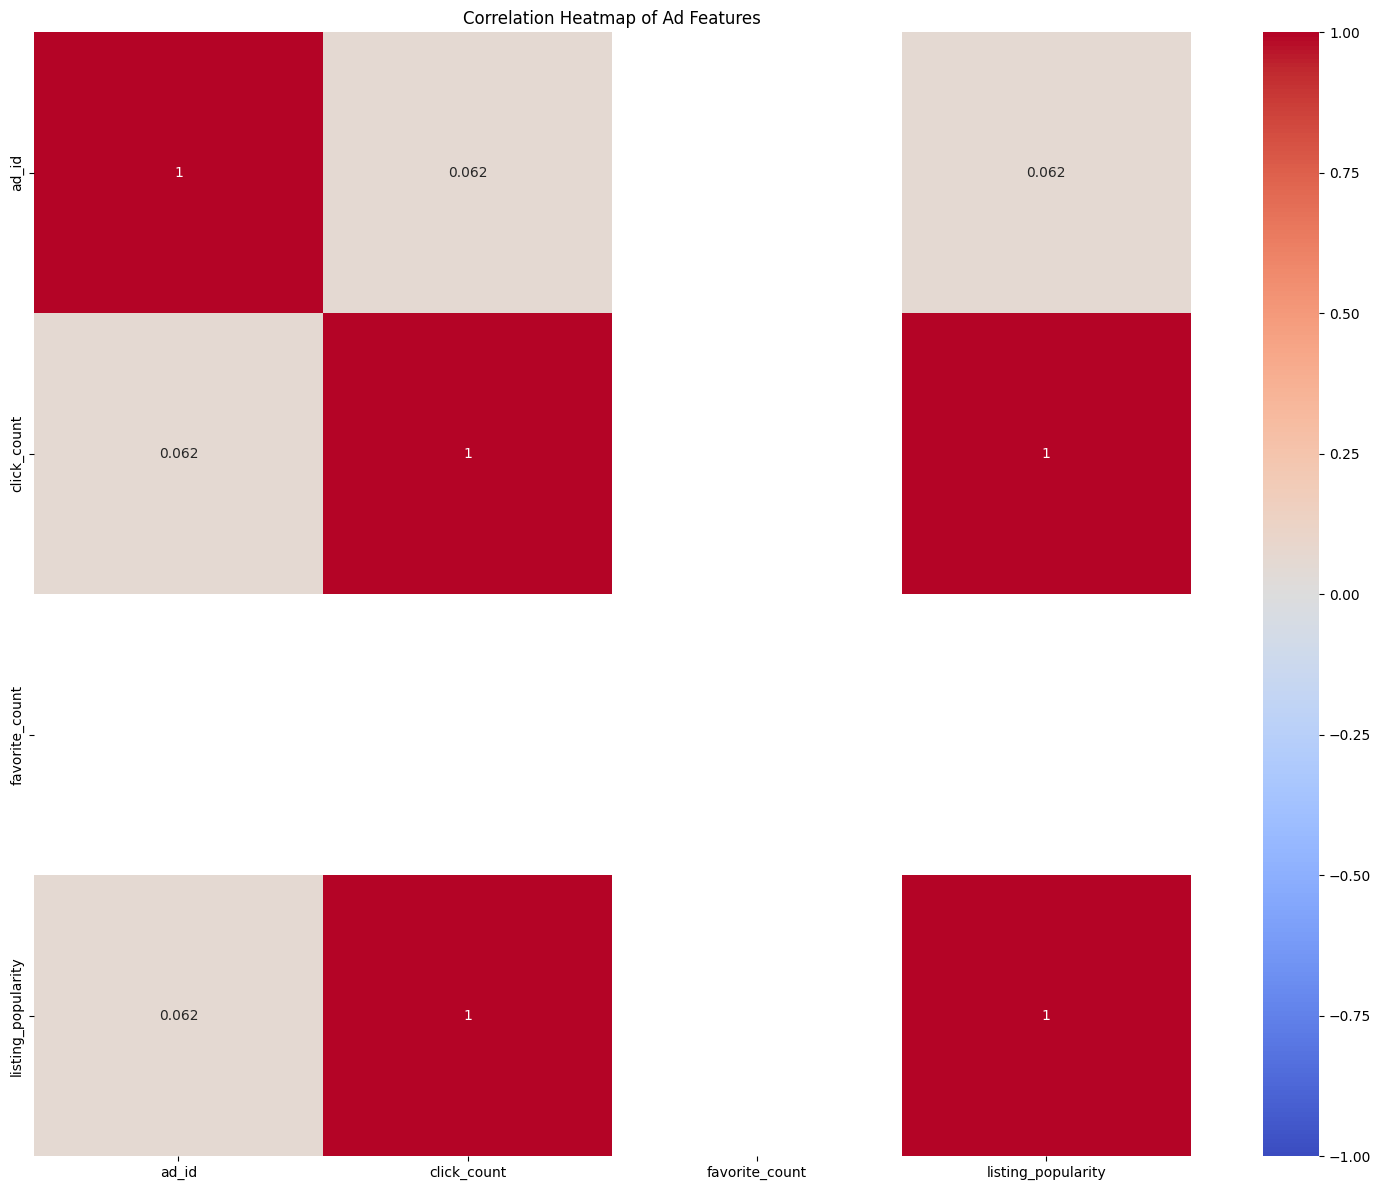

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Select numerical columns
numerical_cols = ad_nodes.select_dtypes(include=['float64', 'int64']).columns

# Compute correlation matrix
corr_matrix = ad_nodes[numerical_cols].corr()

# Plot heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Ad Features')
plt.tight_layout()
plt.show()

In [45]:
unique_counts = ad_nodes.nunique().sort_values(ascending=False)
print(unique_counts)

ad_id                    376782
mahalle                   11223
ilce                        831
click_count                 150
listing_popularity          150
il                           83
ilan_fiyat_category          22
m2_gross_category            21
room_category                 9
building_age_category         9
floor_category                9
kategori_1                    6
kategori_2                    5
site_icinde_mi                2
favorite_count                1
dtype: int64


#### Feature Selection

In [47]:
# List of selected features to keep
selected_features = [
    'ad_id', 'kategori_1', 'kategori_2', 'il', 'ilce', 'mahalle', 'm2_gross_category',
    'room_category', 'floor_category', 'building_age_category', 'ilan_fiyat_category', 'listing_popularity'
]

# SElect the specified features from ad_nodes
ad_nodes_selected = ad_nodes[selected_features]
final_df = pd.merge(merged_df[['ad_id']], ad_nodes_selected, on='ad_id', how='left')
print(final_df.head())
print("\nColumns:")
print(final_df.columns)


      ad_id kategori_1 kategori_2        il        ilce  \
0  127078.0       sale       arsa  İstanbul  Başakşehir   
1  325571.0       sale      konut  İstanbul  Sancaktepe   
2  325571.0       sale      konut  İstanbul  Sancaktepe   
3  325571.0       sale      konut  İstanbul  Sancaktepe   
4  325571.0       sale      konut  İstanbul  Sancaktepe   

                         mahalle m2_gross_category   room_category  \
0  Bahçeşehir 2. Kısım Mahallesi         1000-5000  Not-Applicable   
1        Veysel Karani Mahallesi           130-150         4 Rooms   
2        Veysel Karani Mahallesi           130-150         4 Rooms   
3        Veysel Karani Mahallesi           130-150         4 Rooms   
4        Veysel Karani Mahallesi           130-150         4 Rooms   

   floor_category building_age_category ilan_fiyat_category  \
0  Not-Applicable        Not Applicable                15M+   
1         Unknown             21+ years             5M-7.5M   
2         Unknown             21+ y

In [48]:
final_df.to_csv('ad_nodes.csv', index=False)

In [49]:
print(ad_nodes.isna().sum())

ad_id                      0
kategori_1                 0
kategori_2                 0
room_category              0
floor_category             0
building_age_category      0
m2_gross_category        732
ilan_fiyat_category        0
il                         0
ilce                       0
mahalle                  164
site_icinde_mi           164
click_count                0
favorite_count             0
listing_popularity         0
dtype: int64


## Location Nodes

In [50]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import entropy


In [ ]:
path_data = 'davranis.csv'
path_ad = 'ilan_bilgileri.csv'

interaction = pd.read_csv(path_data)
ad_details = pd.read_csv(path_ad)

# Convert product_id from object to int64
interaction['product_id'] = pd.to_numeric(interaction['product_id'], errors='coerce').astype('Int64')

In [51]:
interaction['product_id'] = pd.to_numeric(interaction['product_id'], errors='coerce').astype('Int64')
merged_df_loc = pd.merge(interaction, ad_details, left_on='product_id', right_on='id', how='outer', suffixes=('_table1', '_ad_details'))
merged_df_loc['ad_id'] = merged_df_loc['product_id'].fillna(merged_df_loc['id'])

In [53]:
merged_df_loc.columns

Index(['session_id', 'timestamp', 'product_id', 'client_id', 'search_id',
       'device_category', 'page_path', 'product_list_name', 'page_number',
       'query', 'event_type', 'transaction_id', 'transaction_type',
       'ds_search_id', 'il_table1', 'ilce_table1', 'mahalle_table1',
       'kategori_3_table1', 'browser_size', 'product_list_position',
       'kategori_1_table1', 'kategori_2_table1', 'others', 'etl_date_table1',
       'id', 'category_id', 'kategori_1_ad_details', 'kategori_2_ad_details',
       'kategori_3_ad_details', 'mahalle_ad_details', 'ilce_ad_details',
       'il_ad_details', 'created_at', 'updated_at', 'ilan_baslik',
       'ilan_fiyat', 'ilan_sahip_adi', 'site_icinde_mi', 'm2_gross', 'm2_net',
       'bina_kat_sayisi', 'etl_date_ad_details', 'row_num', 'cephe',
       'sosyal_imkanlar', 'bina_ozellikleri', 'ulasim', 'oda_sayisi',
       'ilan_kat_sayisi', 'bina_yasi', 'ad_id', 'price_per_m2'],
      dtype='object')

In [65]:
merged_df_loc['timestamp'] = pd.to_datetime(merged_df_loc['timestamp'], errors='coerce')  # Convert to datetime


In [ ]:
def create_location_nodes(merged_df_loc):
    location_nodes = {}

    # Helper function to get top 3 categories
    def get_top_categories(series):
        return [cat for cat, _ in Counter(series).most_common(3)]

    # Helper function to calculate diversity index (using entropy)
    def diversity_index(series):
        counts = Counter(series)
        probabilities = [count / len(series) for count in counts.values()]
        return entropy(probabilities)

    # Calculate price per square meter
    merged_df_loc['price_per_m2'] = merged_df_loc['ilan_fiyat'] / merged_df_loc['m2_gross']

    # Create nodes for each level
    for level in ['il', 'ilce', 'mahalle']:
        grouped = merged_df_loc.groupby(f'{level}_ad_details')
        
        basic_agg = grouped.agg({
            'ad_id': 'count',
            'ilan_fiyat': ['sum', 'mean'],
            'price_per_m2': 'mean',
            'timestamp': ['min', 'max']
        })
        
        # Rename columns appropriately
        basic_agg.columns = [
            'listing_count', 'total_value', 'avg_price', 
            'avg_m2_price', 'earliest_timestamp', 'latest_timestamp'
        ]
        
        # Calculate additional features
        basic_agg['popular_categories'] = grouped['kategori_2_ad_details'].apply(get_top_categories)
        basic_agg['search_count'] = grouped['query'].apply(lambda x: sum(x.str.contains(level, case=False, na=False)))
        basic_agg['view_count'] = grouped['event_type'].apply(lambda x: sum(x != 'click'))
        basic_agg['interaction_count'] = grouped['event_type'].apply(lambda x: sum((x == 'click') | (x == 'favorite')))
        basic_agg['popularity_score'] = (
            basic_agg['search_count'] * 0.5 + 
            basic_agg['view_count'] * 0.3 + 
            basic_agg['interaction_count'] * 0.2
        ) / ((basic_agg['latest_timestamp'] - basic_agg['earliest_timestamp']).dt.days + 1)
        basic_agg['price_trend'] = (basic_agg['avg_price'] - basic_agg.groupby(level=0)['avg_price'].first()) / basic_agg.groupby(level=0)['avg_price'].first()
        basic_agg['diversity_index'] = grouped['kategori_2_ad_details'].apply(diversity_index)

        if level == 'ilce':
            basic_agg['parent_province'] = merged_df_loc.groupby('ilce_ad_details')['il_ad_details'].first()
        elif level == 'mahalle':
            basic_agg['parent_district'] = merged_df_loc.groupby('mahalle_ad_details')['ilce_ad_details'].first()

        location_nodes[level] = basic_agg

    return location_nodes

# Create location nodes
location_nodes = create_location_nodes(merged_df_loc)

# Print sample of each level
for level in ['il', 'ilce', 'mahalle']:
    print(f"\nSample of {level} nodes:")
    print(location_nodes[level].head())


In [78]:
def categorize_location_features(location_nodes):
    for level in ['il', 'ilce', 'mahalle']:
        df = location_nodes[level]
        
        # Count-based features
        count_features = ['listing_count', 'search_count', 'view_count', 'interaction_count']
        for feature in count_features:
            df[f'{feature}_category'] = pd.cut(df[feature], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        
        
        # Price-based features
        price_features = ['total_value', 'avg_price', 'avg_m2_price']
        for feature in price_features:
            df[f'{feature}_category'] = pd.cut(df[feature], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        
        # Popularity score
        df['popularity_category'] = pd.cut(df['popularity_score'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        
        # Price trend
        df['price_trend_category'] = pd.cut(df['price_trend'], 
                                            bins=[-np.inf, -0.1, -0.05, 0.05, 0.1, np.inf], 
                                            labels=['Sharp Decline', 'Slight Decline', 'Stable', 'Slight Increase', 'Sharp Increase'])
        
        # Diversity index
        df['diversity_category'] = pd.cut(df['diversity_index'], bins=3, labels=['Low Diversity', 'Medium Diversity', 'High Diversity'])
        
        location_nodes[level] = df
    
    return location_nodes

# Categorize the features
categorized_location_nodes = categorize_location_features(location_nodes)

# Print sample of each level
for level in ['il', 'ilce', 'mahalle']:
    print(f"\nSample of categorized {level} nodes:")
    print(categorized_location_nodes[level].head())


Sample of categorized il nodes:
                listing_count   total_value     avg_price   avg_m2_price  \
il_ad_details                                                              
Adana                   13023  5.741381e+10  4.418146e+06  243199.669035   
Adıyaman                  519  6.342417e+08  1.222046e+06    4708.099493   
Afyonkarahisar           2449  1.594672e+10  6.522176e+06    9686.450892   
Aksaray                   894  3.008014e+09  3.364669e+06    8903.154292   
Amasya                   1259  1.424860e+09  1.146308e+06    7769.528523   

                    earliest_timestamp        latest_timestamp  \
il_ad_details                                                    
Adana          2023-07-02 21:00:07.502 2023-07-05 16:04:29.740   
Adıyaman       2023-07-02 21:02:59.319 2023-07-04 20:52:50.780   
Afyonkarahisar 2023-07-02 21:00:43.466 2023-07-04 20:59:28.765   
Aksaray        2023-07-02 21:00:22.143 2023-07-05 09:36:19.230   
Amasya         2023-07-02 21:01:27.668

In [60]:
unique_counts = mahalle.nunique().sort_values(ascending=False)
print(unique_counts)


mahalle_ad_details            11223
avg_m2_price                  10842
avg_price                      7928
total_value                    7601
earliest_timestamp             7536
latest_timestamp               7534
diversity_index                2396
popularity_score               1344
parent_district                 762
listing_count                   610
view_count                      441
interaction_count               410
search_count                    252
popular_categories               30
popularity_category               5
total_value_category              5
view_count_category               5
avg_m2_price_category             4
search_count_category             4
listing_count_category            4
interaction_count_category        4
diversity_category                3
avg_price_category                3
price_trend                       1
price_trend_category              1
dtype: int64


In [61]:
merged_df_loc.columns

Index(['session_id', 'timestamp', 'product_id', 'client_id', 'search_id',
       'device_category', 'page_path', 'product_list_name', 'page_number',
       'query', 'event_type', 'transaction_id', 'transaction_type',
       'ds_search_id', 'il_table1', 'ilce_table1', 'mahalle_table1',
       'kategori_3_table1', 'browser_size', 'product_list_position',
       'kategori_1_table1', 'kategori_2_table1', 'others', 'etl_date_table1',
       'id', 'category_id', 'kategori_1_ad_details', 'kategori_2_ad_details',
       'kategori_3_ad_details', 'mahalle_ad_details', 'ilce_ad_details',
       'il_ad_details', 'created_at', 'updated_at', 'ilan_baslik',
       'ilan_fiyat', 'ilan_sahip_adi', 'site_icinde_mi', 'm2_gross', 'm2_net',
       'bina_kat_sayisi', 'etl_date_ad_details', 'row_num', 'cephe',
       'sosyal_imkanlar', 'bina_ozellikleri', 'ulasim', 'oda_sayisi',
       'ilan_kat_sayisi', 'bina_yasi', 'ad_id', 'price_per_m2'],
      dtype='object')

### Feature Selection Approach:

Relevance: Prioritized features directly related to property characteristics (e.g., room_category, m2_gross) and user behavior (e.g., click_count).
Cardinality: Balanced high-cardinality features (e.g., ilce) with more general ones (e.g., il) to avoid overfitting.
Information Content: Focused on features with good distribution (e.g., ilan_fiyat_category) rather than those with low variance.
Redundancy Reduction: Eliminated features providing similar information (e.g., keeping room_category instead of raw oda_sayisi).
Challenges: Deciding which features to keep when faced with correlation or similar information content.


### Challenges and Solutions:

Data Sparsity: Many users had very few interactions. Solution: Created aggregated features and used categorization to extract maximum information from limited data.
Inconsistent Formats: Especially in fields like oda_sayisi and ilan_kat_sayisi. Solution: Developed robust parsing functions to handle various formats.
Skewed Distributions: Many numerical features had long-tail distributions. Solution: Used custom binning strategies, sometimes with logarithmic scales.
Balancing Detail and Generalization: Especially for location data. Solution: Created hierarchical structures allowing for analysis at different granularity levels.
Handling Time-Based Data: Limited historical data available. Solution: Created simple time-based features (e.g., listing age) with plans to expand as more data becomes available.


### Methodological Approaches:

Iterative Refinement: Continuously revisited and refined feature engineering based on data exploration results.
Domain-Specific Knowledge Application: Used understanding of real estate market to create meaningful categories and features.
Data-Driven Decisions: Used data distribution and statistics to inform feature engineering decisions (e.g., bin edges for numerical features).
Graph-Centric Thinking: Designed features with consideration of how they would be used in a graph structure (e.g., creating features that would be meaningful for node similarity calculations).